In [1]:
import sys
sys.path.insert(0, '/home/flipvanrijn/Workspace/Dedicon-Thesis/')

from utils.selective_search.selective_search import *
import numpy
import skimage.io
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.html.widgets import IntSlider, interactive, interact
from IPython.display import display

%matplotlib inline

images = glob.glob('/media/Data/flipvanrijn/datasets/coco/images/train/*.jpg')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


/media/Data/flipvanrijn/datasets/coco/images/train/COCO_train2014_000000017703.jpg


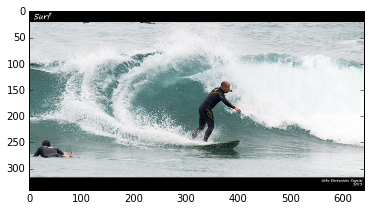

In [2]:
img = None
def selectimg(img_idx):
    global img
    
    print images[img_idx]
    img = skimage.io.imread(images[img_idx])
    
    plt.imshow(img)

image_slider = IntSlider(min=0, max=len(images) - 1, value=0, step=1)
image_widget = interactive(selectimg, img_idx=image_slider)
display(image_widget)

###Color space###

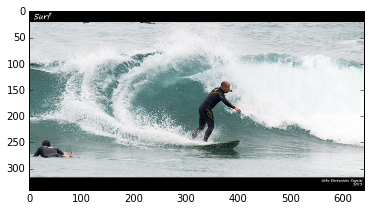

In [3]:
from utils.selective_search.color_space import *

def colorspace(name='rgb'):
    plt.imshow(color_space.convert_color(img, name))
    
colorspace_widget = interact(colorspace, name=['rgb', 'lab', 'rgi', 'hsv', 'nrgb', 'hue'])
display(colorspace_widget)

###Region proposals###

In [4]:
def generate_color_table(R):
    # generate initial color
    colors = numpy.random.randint(0, 255, (len(R), 3))

    # merged-regions are colored same as larger parent
    for region, parent in R.items():
        if not len(parent) == 0:
            colors[region] = colors[parent[0]]

    return colors

In [5]:
selective_search_cache = {}
hierarchical_cache = {}

def visualize(box_idx = 0, hierarchy_idx=0, style='boxes'):
    print 'Calculating...'
    
    global selective_search_cache, hierarchical_cache
    
    img_idx = image_slider.value
    
    if style == 'boxes':
        # Bounding boxes visualization
        t_b = time.time()
        if img_idx in selective_search_cache.keys():
            regions = selective_search_cache[img_idx]
        else:
            regions = selective_search(img, color_spaces=['rgb', 'nrgb', 'hue'], ks=[100, 200], feature_masks=[(0,1,1,0)])
            selective_search_cache[img_idx] = regions
        
        print 'Selected {} regions in {}s...'.format(len(regions), time.time() - t_b)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        plt.imshow(img)
        
        box_idx = box_idx if box_idx <= len(regions) - 1 else len(regions) - 1
        for v, (y0, x0, y1, x1) in regions[:box_idx]:
            ax.add_patch(
                patches.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='green', fill=False)
            )
        plt.show()
    elif style == 'hierarchy':
        # Hierarchical segmentation visualization
        fig, ax = plt.subplots()

        if img_idx in hierarchical_cache.keys():
            results = hierarchical_cache[img_idx]
        else:
            h_output = hierarchical_segmentation(img)
            (R, F, L) = h_output
            
            colors = generate_color_table(R)
            results = []
            for _, label in enumerate(F):
                result = colors[label]
                result = result.astype(numpy.uint8)
                results.append(result)
                
            hierarchical_cache[img_idx] = results
        
        hierarchy_idx = hierarchy_idx if hierarchy_idx <= len(results) - 1 else len(results) - 1
        ax.imshow(results[hierarchy_idx])
    else:
        raise ValueError('Unknown visualization style')

Calculating...


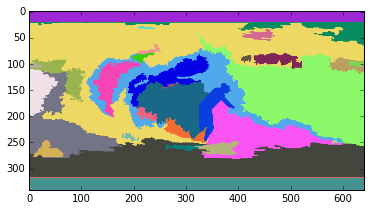

In [6]:
box_slider = IntSlider(min=0, max=10000, value=0, step=1)
hierarchy_slider = IntSlider(min=0, max=1000, value=0, step=1)
image_widget = interactive(visualize, box_idx=box_slider, hierarchy_idx=hierarchy_slider, style=['boxes', 'hierarchy'])
display(image_widget)